In [1]:
# !pip install biopandas
# ! pip install pep517
# !pip install Bio
# !pip install py3Dmol

### Import libraries and packages

In [2]:
import os
import py3Dmol
import numpy as np
import pandas as pd
import scipy.spatial as spatial
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, spectral_clustering, AgglomerativeClustering, DBSCAN, OPTICS, Birch
from Bio.PDB import *
from tqdm import tqdm
from collections import Counter
from biopandas.pdb import PandasPdb
import linecache

### Take example protein

In [3]:
ex_ptn = PandasPdb().read_pdb('sample/zdock_0.pdb')
df = ex_ptn.df['ATOM']
df[df.chain_id == 'B'].head()

record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
3144        ATOM         3146                 N                  GLU           
3145        ATOM         3147                CA                  GLU           
3146        ATOM         3148                 C                  GLU           
3147        ATOM         3149                 O                  GLU           
3148        ATOM         3150                CB                  GLU           

     chain_id  residue_number insertion  ... x_coord  y_coord  z_coord  \
3144        B              10            ...   -4.80    99.40    -7.28   
3145        B              10            ...   -5.80    99.95    -8.19   
3146        B              10            ...   -6.14   101.43    -7.96   
3147        B              10            ...   -6.22   102.16    -8.96   
3148        B              10            ...   -7.09    99.11    -8.20   

      occupancy  b_factor  blank_4 segment_id element_symbol charge  line_idx  
3144        1.0       0.0                                  N    NaN      3146  
3145        1.0       0.0                                  C    NaN      3147  
3146        1.0       0.0                                  C    NaN      3148  
3147        1.0       0.0                                  O    NaN      3149  
3148        1.0       0.0                                  C    NaN      3150  

[5 rows x 21 columns]

### Get 3 most distant points in protein

In [4]:
def distances(ndarray_0, ndarray_1):
    if (ndarray_0.ndim, ndarray_1.ndim) not in ((1, 2), (2, 1)):
        raise ValueError("bad ndarray dimensions combination")
    return np.linalg.norm(ndarray_0 - ndarray_1, axis=1)

def get_most_dist_points(data, K, MAX_LOOPS=20, plot=False, alpha=0.3):
    N = data.shape[0]
    ND = data.shape[1]
    # start with the K points closest to the mean
    indices = np.argsort(distances(data, data.mean(0)))[:K].copy()
    # distsums is, for all N points, the sum of the distances from the K points
    distsums = spatial.distance.cdist(data, data[indices]).sum(1)
    # but the K points themselves should not be considered
    # (the trick is that -np.inf ± a finite quantity always yields -np.inf)
    distsums[indices] = -np.inf
    prev_sum = 0.0
    for loop in range(MAX_LOOPS):
        for i in range(K):
            # remove this point from the K points
            old_index = indices[i]
            # calculate its sum of distances from the K points
            distsums[old_index] = distances(data[indices], data[old_index]).sum()
            # update the sums of distances of all points from the K-1 points
            distsums -= distances(data, data[old_index])
            # choose the point with the greatest sum of distances from the K-1 points
            new_index = np.argmax(distsums)
            # add it to the K points replacing the old_index
            indices[i] = new_index
            # don't consider it any more in distsums
            distsums[new_index] = -np.inf
            # update the sums of distances of all points from the K points
            distsums += distances(data, data[new_index])
        # sum all mutual distances of the K points
        curr_sum = spatial.distance.pdist(data[indices]).sum()
        # break if the sum hasn't changed
        if curr_sum == prev_sum:
            break
        prev_sum = curr_sum

        if print:
            if ND == 2:
                X, Y = data.T
                marker_size = 4
                plt.scatter(X, Y, s=marker_size)
                plt.scatter(X[indices], Y[indices], s=marker_size*4, color='red')
                plt.grid(True)
                plt.gca().set_aspect('equal', adjustable='box')
                plt.show()

            elif ND == 3:
                fig = plt.figure()
                ax = fig.add_subplot(projection='3d')
                X, Y, Z = data.T
                marker_size = 4
                ax.scatter(X, Y, Z, s=marker_size, color='lightblue', alpha=alpha)
                ax.scatter(X[indices], Y[indices], Z[indices], s=marker_size*4, color='red', marker='s')
                plt.grid(True)
                plt.show()

        else:
            print(f'Dimensions {ND} are plottable')
    return indices


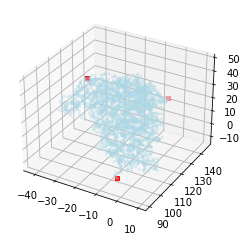

x_coord  y_coord  z_coord
atom_number                           
3154           -5.83    97.69   -11.11
5112          -25.52   107.68    46.88
4443           -6.41   146.02    13.62

In [5]:
dfB = df[df.chain_id == 'B'].set_index('atom_number')[['x_coord', 'y_coord', 'z_coord']]
result = get_most_dist_points(dfB.values, K=3, plot=True)
i,j,k = dfB.iloc[result].index
dfB.iloc[result]

### Get 3-atom (9-coordinate) representation of each .pdb file

In [6]:
# INNEFICIENT
# for file_name in tqdm(file_names):
#     pl1 = PandasPdb().read_pdb(file_name)
#     df = pl1.df['ATOM']
#     dfB = df[df.chain_id == 'B'].set_index('atom_number')[['x_coord', 'y_coord', 'z_coord']]
#     coords = dfB.loc[[i,j,k]].values.flatten()
# #     print(coords)
#     result[count,:] = coords
#     count += 1  
# result

In [16]:
docking_programs = ['zdock', 'ftdock', 'rosetta', 'patchdock', 'lightdock']

for docking_program in docking_programs:
    file_names = [f'{docking_program}/' + f for f in os.listdir(f'{docking_program}/') if f.endswith(".pdb")]
    result = np.zeros((len(file_names), 9))
    row = 0

    df = pd.DataFrame(columns=('x', 'y', 'z'))
    for file_name in tqdm(file_names):
        l = count = 0
        for q,l in enumerate([i,j,k]):
            line = linecache.getline(file_name, l+1)            
            df.loc[q] = [line[30:38], line[38:46], line[46:54]]
        result[row,:] = df.values.flatten()
        row += 1
        linecache.clearcache()
#         for line in open(file_name):
#             if count in [i, j ,k]:
#                 df.loc[l] = [line[30:38], line[38:46], line[46:54]]
#                 l += 1
#             count += 1
#         coords = df.values.flatten()
#         result[row,:] = coords
#         row+=1

    df_result = pd.DataFrame(result, columns=['x1','y1','z1','x2','y2','z2','x3','y3','z3'])
    df_result.to_csv(f'result_{docking_program}.csv', index=False)

100%|██████████| 70343/70343 [09:10<00:00, 127.80it/s]


### Clustering

In [8]:
datasets = ['result_ftdock.csv'] #['result_zdock.csv', 'result_ftdock.csv', 'result_rosetta.csv', 'result_patchdock.csv', 'result_lightdock.csv']#
file_names = []
# file_names = ['zdock/' + f for f in os.listdir("./zdock/") if f.endswith(".pdb")]
file_names = file_names + ['ftdock/' + f for f in os.listdir("./ftdock/") if f.endswith(".pdb")]
# file_names = file_names + ['rosetta/' + f for f in os.listdir("./rosetta/") if f.endswith(".pdb")]
# file_names = file_names + [ 'patchdock/' + f for f in os.listdir("./patchdock/") if f.endswith(".pdb")]
# file_names = file_names + [ 'lightdock/' + f for f in os.listdir("./lightdock/") if f.endswith(".pdb")]
dfs = []
for d in datasets:
    df = pd.read_csv(d)
    df.columns=['x1','y1','z1','x2','y2','z2','x3','y3','z3']
    dfs.append(df)
df_result = pd.concat(dfs).reset_index(drop=True)
df_result

x1      y1     z1      x2      y2     z2     x3      y3     z3
0      58.82  182.17  -0.28   91.16  131.30 -14.98  38.49  138.71 -25.60
1      66.25   91.67  23.33   68.99  148.27  48.57  27.15  114.11  53.53
2      61.60  160.18  30.08    3.75  150.96   9.57  22.01  136.27  58.51
3     109.69  107.56 -44.76   50.43   97.01 -59.75  67.41  135.93 -26.00
4      10.73   72.38 -64.27   40.71   77.49 -10.17  33.14  118.08 -45.38
...      ...     ...    ...     ...     ...    ...    ...     ...    ...
9995   -2.39   75.39 -37.57   20.71  131.86 -48.81   5.82  113.60   0.07
9996   43.42  154.76 -17.42  101.05  148.12 -39.46  70.91  107.96 -18.85
9997   32.35  152.84  22.05   45.60  112.15  66.97  82.26  135.68  34.65
9998    4.33  108.24   1.48   60.96   90.71  19.65  35.22   71.73 -24.18
9999   18.53  114.67 -60.27   30.69  138.87  -4.44 -17.80  139.71 -28.71

[10000 rows x 9 columns]

In [9]:
len(file_names)

10000

In [12]:
# model = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', distance_threshold=3*2*8.0)
model = KMeans(n_clusters=20)
# model = DBSCAN(eps=3*8, metric='euclidean')
# model = OPTICS(cluster_method='xi', eps=3*7, xi=0.1)
# model = Birch(n_clusters=5)

In [13]:
%%time
model.fit(df_result.values)

Wall time: 759 ms


KMeans(n_clusters=20)

In [621]:
list(model.labels_)
f = open('labels.txt', 'w')
for lab in model.labels_:
    f.write(str(lab)+ '\n')
f.close()

In [622]:
top_clusters = sorted([(a,b) for a,b in Counter(model.labels_).items() if b>1], key=lambda x: -x[1])
print('Num cluster:', len(top_clusters))
print('Top 10 clusters:')
top_clusters[:10]

Num cluster: 1243
Top 10 clusters:


[(0, 90086),
 (-1, 8546),
 (543, 184),
 (560, 174),
 (369, 172),
 (377, 163),
 (28, 141),
 (250, 138),
 (501, 138),
 (59, 132)]

### Visualize clusters representatives and RMSD

In [623]:
def read_df(fname):
    pl1 = PandasPdb().read_pdb(fname)
    df = pl1.df['ATOM']
    df = df.set_index('atom_number')[['x_coord', 'y_coord', 'z_coord']]
    return df

In [624]:
def pdbviz_1(filename, cartoon=True, stick=True):
    f = py3Dmol.view()

    if (not cartoon) and (not stick):
        return print("At least one must be True")

    if cartoon:
        f.addModel(open(filename, 'r').read(),'pdb')
        f.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})

    if stick:
        f.addModel(open(filename, 'r').read(),'pdb')
        f.setStyle({'model': -1}, {"stick": {'color': 'spectrum'}})

    f.setBackgroundColor('white')
    f.zoomTo()

    f.show()

def pdbviz_1_mod(a_pdb, b_pdb):
    f = py3Dmol.view()

    f.addModel(open(a_pdb, 'r').read(),'pdb')
    f.setStyle({'model': -1}, {"stick": {'color': 'spectrum'}})
    f.addModel(open(b_pdb, 'r').read(),'pdb')
    f.setStyle({'model': -1}, {"stick": {'color': 'orange'}})

    f.setBackgroundColor('white')
    f.zoomTo()
    f.show()

In [627]:
# Save A protein
A = PandasPdb().read_pdb(file_names[0]).df['ATOM']
A = A[A.chain_id == 'A'].copy()
pdb = PandasPdb().read_pdb(file_names[0])
pdb.df['ATOM'] = A
pdb.to_pdb(path=f'./A.pdb')

In [628]:
reference = PandasPdb().read_pdb('reference_structure.pdb')
rmsds = []
for num_c, (c, num_elems) in enumerate(top_clusters[:10]):
    cluster = df_result[model.labels_ == c]
    cluster_files = np.array(file_names)[cluster.index.values]
    # print(f'{num_c})', "Cluster:", c, num_elems), any(['zdock_1577' in cfile for cfile in cluster_files]))
    index = np.argsort(distances(cluster, cluster.mean(0)))[:1]
    representant_file = file_names[cluster.iloc[index].index[0]]
    
    # Save B protein
    B = PandasPdb().read_pdb(representant_file).df['ATOM']
    B = B[B.chain_id == 'B'].copy()
    pdb = PandasPdb().read_pdb(representant_file)
    pdb.df['ATOM'] = B
    pdb.to_pdb(path=f'./representant_cluster_{c}.pdb')
    
    # Save A and B proteins together
    rep = PandasPdb().read_pdb(representant_file)
    rep.to_pdb(f'cluster{num_c}.pdb')
    
    rmsd = PandasPdb.rmsd(rep.df['ATOM'], reference.df['ATOM'],)
    
#     print(f'Cluster {c}:')
#     df = None
#     for fname in tqdm(cluster_files):
#         if df is None:
#             df = read_df(fname).values
#         else:
#             df += read_df(fname).values

#     df_avg = df / len(cluster_files) 

#     pl1 = PandasPdb().read_pdb(cluster_files[0])
#     pl1.df['ATOM'][['x_coord', 'y_coord', 'z_coord']] = df_avg
#     pl1.to_pdb(path=f'./cluster{c}.pdb')
    
    print("---------------------------------------------------------------------------------------")
    print("Cluster number:\t\t", c)
    print("Elements in cluster:\t", num_elems)
    print("RMSD to reference:\t", rmsd)
    
#     pdbviz_1(representant_file, cartoon=False)
    pdbviz_1_mod('A.pdb', f'representant_cluster_{c}.pdb')
#     pdbviz_1(f'./cluster{c}.pdb', cartoon=False)

#  51.227 53 55 

---------------------------------------------------------------------------------------
Cluster number:		 0
Elements in cluster:	 90086
RMSD to reference:	 51.227
---------------------------------------------------------------------------------------
Cluster number:		 -1
Elements in cluster:	 8546
RMSD to reference:	 51.063
---------------------------------------------------------------------------------------
Cluster number:		 543
Elements in cluster:	 184
RMSD to reference:	 57.9887
---------------------------------------------------------------------------------------
Cluster number:		 560
Elements in cluster:	 174
RMSD to reference:	 57.185
---------------------------------------------------------------------------------------
Cluster number:		 369
Elements in cluster:	 172
RMSD to reference:	 58.2939
---------------------------------------------------------------------------------------
Cluster number:		 377
Elements in cluster:	 163
RMSD to reference:	 57.9323
-------------------

In [ ]:
pdbviz_1('reference_structure.pdb', cartoon=False)

In [647]:
rmsd_top = [[65.3504,  64.2199,  60.1248,  62.8353,  64.1798,  59.4414,  62.2038,  60.4779,  61.4537], 
            [60.7291,  64.8075,  55.7336,  55.0582,  59.902,  59.2685,  62.8353,  64.1798,  58.6725],
            [55.5082,  55.8426,  59.9584,  64.2736,  55.2235,  54.5559,  53.8018,  56.7792,  58.0145],
            [52.7307,  61.4537,  57.1353,  58.7669,  58.0874,  57.3219,  61.6303,  55.4525,  58.0517]]

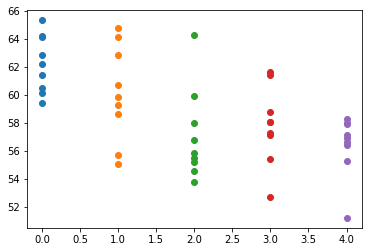

In [634]:
import seaborn as sns

for i, rmsd in enumerate(rmsd_top):
    plt.scatter([i]*len(rmsd), rmsd)

plt.show()

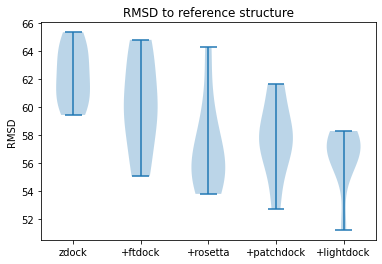

In [646]:
plt.violinplot(rmsd_top)
programs = ['zdock', '+ftdock', '+rosetta', '+patchdock', '+lightdock']
plt.xticks([1,2,3,4,5], programs)
plt.title('RMSD to reference structure')
plt.ylabel('RMSD')
plt.savefig('violinplot.png', dpi=300)

### Visualization of AdaptivePELE clusters

In [388]:
reference = PandasPdb().read_pdb('reference_structure.pdb')

cluster_files = [ 'clusters_AdaptivePELE/' + f for f in os.listdir("clusters_AdaptivePELE/") if f.endswith(".pdb")]

for fname in cluster_files:
    l_1 = PandasPdb().read_pdb(fname)
    r = PandasPdb.rmsd(l_1.df['ATOM'], reference.df['ATOM'], s='main chain')
    print("---------------------------------------------------------------------------------------")
    print("Name:", fname)
    print("RMSD:", r)
    pdbviz_1(fname, cartoon=False)

---------------------------------------------------------------------------------------
Name: clusters_AdaptivePELE/cluster_13.pdb
RMSD: 64.9931


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---------------------------------------------------------------------------------------
Name: clusters_AdaptivePELE/cluster_24.pdb
RMSD: 61.2252


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---------------------------------------------------------------------------------------
Name: clusters_AdaptivePELE/cluster_31.pdb
RMSD: 62.5375


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---------------------------------------------------------------------------------------
Name: clusters_AdaptivePELE/cluster_33.pdb
RMSD: 63.2487


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---------------------------------------------------------------------------------------
Name: clusters_AdaptivePELE/cluster_34.pdb
RMSD: 64.1294


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol